## Mini BERT Pre-training

**프로젝트 목표:**
1. `vocab_size`를 8000으로, 전체 파라미터 크기를 약 1M 내외로 줄인 Mini BERT 모델을 구현
2. 위키피디아와 같은 대규모 텍스트 데이터셋을 사용하여 모델을 10 Epoch까지 학습

### 1. 라이브러리 임포트

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

### 2. 데이터 준비 (Data Preparation)

In [2]:
data_dir = 'data'
model_dir = 'models'
corpus_file = f'{data_dir}/kowiki.txt'

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_8000.model")

# 특수 토큰을 제외한 단어 목록 생성 (MLM에서 랜덤 단어 선택 시 사용)
vocab_list = []
for id in range(7, len(vocab)):
    if not vocab.is_unknown(id):
        vocab_list.append(vocab.id_to_piece(id))

#### Pre-training 데이터 생성 함수

1.  **Masked Language Model (MLM):** 문장에서 일부 토큰을 `[MASK]`로 바꾸고, 모델이 원래 토큰을 맞추도록 학습합니다. 이를 통해 문맥을 이해하는 능력 키움
2.  **Next Sentence Prediction (NSP):** 두 문장이 주어졌을 때, 두 번째 문장이 첫 번째 문장의 바로 다음 문장인지 맞추도록 학습합니다. 이를 통해 문장 간의 관계를 이해하는 능력 키움

In [3]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    '''
    Masked Language Model(MLM)을 위한 마스크를 생성합니다.
    - 80%는 `[MASK]` 토큰으로 교체
    - 10%는 원래 토큰을 그대로 유지
    - 10%는 어휘 목록에서 랜덤으로 추출한 토큰으로 교체
    '''
    # 띄어쓰기 단위로 mask하기 위해 index 분할
    cand_idx = []
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u'▁'):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    random.shuffle(cand_idx)

    mask_lms = []
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:
            break
        if len(mask_lms) + len(index_set) > mask_cnt:
            continue
        
        dice = random.random()  # 0과 1 사이의 확률 값
        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9:  # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

def trim_tokens(tokens_a, tokens_b, max_seq):
    '''두 토큰 리스트의 총 길이가 max_seq를 넘지 않도록 자릅니다.'''
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break
        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    '''하나의 문서(doc)에서 pre-training을 위한 여러 instance를 생성합니다.'''
    # for [CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])
        current_length += len(doc[i])
        if i == len(doc) - 1 or current_length >= max_seq:
            if current_chunk:
                a_end = 1
                if len(current_chunk) > 1:
                    a_end = random.randrange(1, len(current_chunk))

                tokens_a = []
                for j in range(a_end):
                    tokens_a.extend(current_chunk[j])

                tokens_b = []
                for j in range(a_end, len(current_chunk)):
                    tokens_b.extend(current_chunk[j])

                # 50% 확률로 A와 B 순서를 바꿔 NSP 레이블을 0으로 설정 (IsNext=False)
                if random.random() < 0.5:
                    is_next = 0
                    tokens_a, tokens_b = tokens_b, tokens_a
                else:
                    is_next = 1

                trim_tokens(tokens_a, tokens_b, max_seq)
                if not tokens_a or not tokens_b:
                    continue

                tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
                segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

                mask_cnt = int((len(tokens) - 3) * mask_prob)
                tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

                instance = {
                    "tokens": tokens,
                    "segment": segment,
                    "is_next": is_next,
                    "mask_idx": mask_idx,
                    "mask_label": mask_label
                }
                instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

In [4]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    ''' pretrain 데이터 생성 '''
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":
                    if doc:
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:
                    pieces = vocab.encode_as_pieces(line)
                    if pieces:
                        doc.append(pieces)
            if doc:
                save_pretrain_instances(out_f, doc)

def load_pre_train_data(vocab, filename, n_vocab, n_seq, count=None):
    """ 학습에 필요한 데이터를 로드 """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            if count is not None and count <= total:
                break

    unk_id = vocab.piece_to_id('[UNK]')

    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                break
            data = json.loads(line)

            # encoder token: vocab_size를 초과하는 ID는 [UNK] 토큰으로 변경
            enc_token_ids = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token = [id if id < n_vocab else unk_id for id in enc_token_ids]
            enc_token += [0] * (n_seq - len(enc_token))

            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))

            label_nsp = data["is_next"]

            # mlm label
            label_mlm = np.full(n_seq, dtype=np.int32, fill_value=0)
            if data["mask_idx"]: # mask_idx가 비어있지 않은 경우에만 처리
                mask_idx = np.array(data["mask_idx"], dtype=np.int32)
                mask_label_ids = [vocab.piece_to_id(p) for p in data["mask_label"]]
                mask_label = np.array([id if id < n_vocab else unk_id for id in mask_label_ids], dtype=np.int32)
                label_mlm[mask_idx] = mask_label

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

### 3. BERT 모델 구현

#### 유틸 메소드 및 클래스

In [5]:
def get_pad_mask(tokens, i_pad=0):
    '''패딩 마스크(pad: 1, other: 0)'''
    mask = (tokens == i_pad)
    mask = mask.unsqueeze(1).unsqueeze(2) # (bs, 1, 1, n_seq)
    return mask

def get_ahead_mask(tokens, i_pad=0):
    '''어텐션 마스크(ahead or pad: 1, other: 0)'''
    n_seq = tokens.size(1)
    ahead_mask = 1 - torch.tril(torch.ones(n_seq, n_seq)).type_as(tokens)
    ahead_mask = ahead_mask.unsqueeze(0).unsqueeze(1) # (1, 1, n_seq, n_seq)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = torch.maximum(ahead_mask, pad_mask)
    return mask

def gelu(x):
    '''GELU 활성화 함수'''
    return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

class Config(dict):
    '''json을 config 형태로 사용하기 위한 클래스'''
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

#### 임베딩 (Embeddings)

1.  **Token Embedding:** 각 토큰의 의미를 나타내는 임베딩입니다. MLM 예측을 위해 출력층과 가중치를 공유하는 `SharedEmbedding`
2.  **Position Embedding:** 토큰의 위치 정보를 나타내는 임베딩
3.  **Segment Embedding:** 두 문장을 구분하기 위한 임베딩 (문장 A는 0, 문장 B는 1)

In [6]:
class SharedEmbedding(nn.Module):
    '''출력층과 가중치를 공유하는 임베딩'''
    def __init__(self, config):
        super().__init__()
        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
        self.shared_weights = nn.Parameter(torch.empty(self.n_vocab, self.d_model))
        nn.init.trunc_normal_(self.shared_weights, std=0.02)

    def forward(self, inputs, mode="embedding"):
        if mode == "embedding":
            return self._embedding(inputs)
        elif mode == "linear":
            return self._linear(inputs)
        else:
            raise ValueError(f"mode {mode} is not valid.")

    def _embedding(self, inputs):
        return F.embedding(inputs, self.shared_weights)

    def _linear(self, inputs):
        return F.linear(inputs, self.shared_weights)

class PositionEmbedding(nn.Module):
    '''Position Embedding'''
    def __init__(self, config):
        super().__init__()
        self.embedding = nn.Embedding(config.n_seq, config.d_model)
        nn.init.trunc_normal_(self.embedding.weight, std=0.02)

    def forward(self, inputs):
        position = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), -1)
        return self.embedding(position)

class SegmentEmbedding(nn.Module):
    '''Segment Embedding'''
    def __init__(self, config):
        super().__init__()
        self.embedding = nn.Embedding(2, config.d_model)
        nn.init.trunc_normal_(self.embedding.weight, std=0.02)

    def forward(self, inputs):
        return self.embedding(inputs)

In [7]:
class ScaleDotProductAttention(nn.Module):
    '''Scale Dot Product Attention'''
    def __init__(self, config):
        super().__init__()
        self.config = config

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(self.config.d_head)
        scores.masked_fill_(attn_mask, -1e9)
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

class MultiHeadAttention(nn.Module):
    '''Multi-Head Attention'''
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.W_Q = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_K = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_V = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.attention = ScaleDotProductAttention(config)
        self.linear = nn.Linear(config.n_head * config.d_head, config.d_model)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1, 2)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1, 2)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1, 2)

        attn_mask = attn_mask.repeat(1, self.config.n_head, 1, 1)

        context, attn = self.attention(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        output = self.linear(context)
        output = self.dropout(output)
        return output, attn

In [8]:
class PositionWiseFeedForward(nn.Module):
    '''Position-wise Feed-Forward Network'''
    def __init__(self, config):
        super().__init__()
        self.W_1 = nn.Linear(config.d_model, config.d_ff)
        self.W_2 = nn.Linear(config.d_ff, config.d_model)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, inputs):
        output = gelu(self.W_1(inputs))
        output = self.W_2(output)
        output = self.dropout(output)
        return output

class EncoderLayer(nn.Module):
    '''Encoder Layer'''
    def __init__(self, config):
        super().__init__()
        self.self_attn = MultiHeadAttention(config)
        self.layer_norm1 = nn.LayerNorm(config.d_model, eps=1e-12)
        self.pos_ffn = PositionWiseFeedForward(config)
        self.layer_norm2 = nn.LayerNorm(config.d_model, eps=1e-12)

    def forward(self, inputs, attn_mask):
        # Multi-Head Attention
        attn_outputs, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
        # Residual Connection & Layer Normalization
        attn_outputs = self.layer_norm1(inputs + attn_outputs)
        
        # Position-wise Feed-Forward
        ffn_outputs = self.pos_ffn(attn_outputs)
        # Residual Connection & Layer Normalization
        ffn_outputs = self.layer_norm2(attn_outputs + ffn_outputs)
        
        return ffn_outputs, attn_prob

In [9]:
class BERT(nn.Module):
    '''BERT Model'''
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = SharedEmbedding(config)
        self.position_embedding = PositionEmbedding(config)
        self.segment_embedding = SegmentEmbedding(config)
        self.layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.n_layer)])
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, enc_tokens, segments):
        # Embedding
        token_embed = self.embedding(enc_tokens)
        pos_embed = self.position_embedding(enc_tokens)
        seg_embed = self.segment_embedding(segments)
        seq_embed = token_embed + pos_embed + seg_embed
        seq_embed = self.dropout(seq_embed)

        # Attention Mask
        attn_pad_mask = get_pad_mask(enc_tokens)

        attn_probs = []
        outputs = seq_embed
        for layer in self.layers:
            outputs, attn_prob = layer(outputs, attn_pad_mask)
            attn_probs.append(attn_prob)

        return outputs, attn_probs

class BERTPretrain(nn.Module):
    '''BERT Pre-training Model'''
    def __init__(self, config):
        super().__init__()
        self.bert = BERT(config)
        
        # NSP Head
        self.projection_nsp = nn.Linear(config.d_model, 2)
        
        # MLM Head
        self.projection_mlm = nn.Linear(config.d_model, config.d_model)
        self.gelu = gelu
        self.layer_norm = nn.LayerNorm(config.d_model, eps=1e-12)
        # 최종 출력은 SharedEmbedding의 가중치를 공유하여 vocab_size로 projection

    def forward(self, enc_tokens, segments):
        outputs, attn_probs = self.bert(enc_tokens, segments)
        
        # NSP logits
        # [CLS] 토큰의 출력만 사용
        cls_output = outputs[:, 0, :].contiguous()
        logits_nsp = self.projection_nsp(cls_output)
        
        # MLM logits
        mlm_output = self.projection_mlm(outputs)
        mlm_output = self.gelu(mlm_output)
        mlm_output = self.layer_norm(mlm_output)
        logits_mlm = self.bert.embedding(mlm_output, mode="linear")
        
        return logits_nsp, logits_mlm, attn_probs

### 4. Pre-training 실행

이제 모델 학습을 위한 설정을 정의하고, 학습 루프를 실행

#### 모델 설정 (Configuration)

- Mini BERT를 위한 하이퍼파라미터를 설정
- `vocab_size`, `d_model`, `n_layer` 등을 조절하여 모델의 크기를 결정
- 아래 설정은 약 1.4M개의 파라미터

In [10]:
bert_config = Config({
    "n_vocab": 8000,      # vocab size (줄임)
    "n_seq": 128,         # sequence length
    "d_model": 128,       # model dimension (줄임)
    "n_layer": 2,         # number of layers (줄임)
    "n_head": 4,          # number of heads (줄임)
    "d_head": 32,         # head dimension
    "d_ff": 512,          # feed_forward dimension (d_model * 4)
    "dropout": 0.1,
    "learning_rate": 4e-4 # 3e-4 -> 4e-4
})

# 모델 파라미터 수 계산
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = BERTPretrain(bert_config)
print(f'Total parameters: {count_parameters(model):,}')

Total parameters: 1,454,210


In [11]:
pretrain_json_path = 'bert_pre_train.json'

# 필요 시에만 주석을 해제하고 실행
# print('Making pre-training data...')
# make_pretrain_data(vocab, corpus_file, pretrain_json_path, bert_config.n_seq)
# print('Done.')

# 학습 데이터 로드 (128000건만 테스트용으로 로드)
print('Loading pre-training data...')
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, bert_config.n_vocab, bert_config.n_seq, count=128000)
print('Done.')

Loading pre-training data...


  0%|          | 0/128000 [00:00<?, ?it/s]

Done.


In [12]:
class CosineSchedule:
    """
    CosineSchedule Class for learning rate scheduling
    """
    def __init__(self, optimizer=None, train_steps=4000, warmup_steps=500, max_lr=2.5e-4):
        """
        생성자
        :param optimizer: Optimizer (PyTorch optimizer)
        :param train_steps: 총 학습 step 수
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        self.optimizer = optimizer
        self.train_steps = train_steps
        self.warmup_steps = warmup_steps
        self.max_lr = max_lr
        self.step_num = 0

    def get_lr(self):
        """
        learning rate 계산
        :return: 계산된 learning rate
        """
        if self.step_num <= self.warmup_steps:
            lr = (self.step_num / self.warmup_steps) * self.max_lr
        else:
            progress = (self.step_num - self.warmup_steps) / max(1, self.train_steps - self.warmup_steps)
            lr = 0.5 * self.max_lr * (1 + math.cos(math.pi * progress))
        return lr

    def step(self):
        """
        Step 함수: 매 학습 step마다 호출하여 learning rate를 업데이트
        """
        self.step_num += 1
        return self.get_lr()

In [13]:
# train_bert 함수 위에 CosineSchedule 클래스가 정의되어 있어야 합니다.

def train_bert(config, model, train_inputs, train_labels):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    # Dataset 및 DataLoader 생성
    dataset = TensorDataset(torch.tensor(train_inputs[0], dtype=torch.long),
                            torch.tensor(train_inputs[1], dtype=torch.long),
                            torch.tensor(train_labels[0], dtype=torch.long),
                            torch.tensor(train_labels[1], dtype=torch.long))

    batch_size = 16
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Loss 함수
    loss_nsp = nn.CrossEntropyLoss()
    loss_mlm = nn.CrossEntropyLoss(ignore_index=0)

    # CosineSchedule 설정
    epochs = 10
    total_steps = len(dataloader) * epochs
    warmup_steps = len(dataloader) # 1 에포크 동안 warm-up
    # config의 learning_rate를 max_lr로 사용
    scheduler = CosineSchedule(optimizer, train_steps=total_steps, warmup_steps=warmup_steps, max_lr=config.learning_rate)

    # Loss history 저장용
    history = {'total_loss': [], 'nsp_loss': [], 'mlm_loss': [], 'lr': []}

    model.train()
    for epoch in range(epochs):
        epoch_total_loss = 0
        for step, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
            # 매 스텝마다 learning rate 업데이트
            lr = scheduler.step()
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

            batch = tuple(t.to(device) for t in batch)
            enc_tokens, segments, labels_nsp, labels_mlm = batch

            optimizer.zero_grad()

            logits_nsp, logits_mlm, _ = model(enc_tokens, segments)

            cost_nsp = loss_nsp(logits_nsp, labels_nsp)
            cost_mlm = loss_mlm(logits_mlm.view(-1, config.n_vocab), labels_mlm.view(-1))
            cost = cost_nsp + cost_mlm

            cost.backward()
            optimizer.step()

            # Store losses and learning rate for each step
            history['total_loss'].append(cost.item())
            history['nsp_loss'].append(cost_nsp.item())
            history['mlm_loss'].append(cost_mlm.item())
            history['lr'].append(lr)

            epoch_total_loss += cost.item()

        print(f"Epoch {epoch+1} average loss: {epoch_total_loss / len(dataloader):.4f}")

    torch.save(model.state_dict(), "mini_bert_pretrained.pth")
    print("Model saved!")

    return history

# 학습 시작 및 history 저장
history = train_bert(bert_config, model, pre_train_inputs, pre_train_labels)

Epoch 1/10:   0%|          | 0/8000 [00:00<?, ?it/s]

Epoch 1 average loss: 7.9341


Epoch 2/10:   0%|          | 0/8000 [00:00<?, ?it/s]

Epoch 2 average loss: 6.9315


Epoch 3/10:   0%|          | 0/8000 [00:00<?, ?it/s]

Epoch 3 average loss: 5.9681


Epoch 4/10:   0%|          | 0/8000 [00:00<?, ?it/s]

Epoch 4 average loss: 5.6617


Epoch 5/10:   0%|          | 0/8000 [00:00<?, ?it/s]

Epoch 5 average loss: 5.5084


Epoch 6/10:   0%|          | 0/8000 [00:00<?, ?it/s]

Epoch 6 average loss: 5.4007


Epoch 7/10:   0%|          | 0/8000 [00:00<?, ?it/s]

Epoch 7 average loss: 5.3143


Epoch 8/10:   0%|          | 0/8000 [00:00<?, ?it/s]

Epoch 8 average loss: 5.2447


Epoch 9/10:   0%|          | 0/8000 [00:00<?, ?it/s]

Epoch 9 average loss: 5.1952


Epoch 10/10:   0%|          | 0/8000 [00:00<?, ?it/s]

Epoch 10 average loss: 5.1681
Model saved!


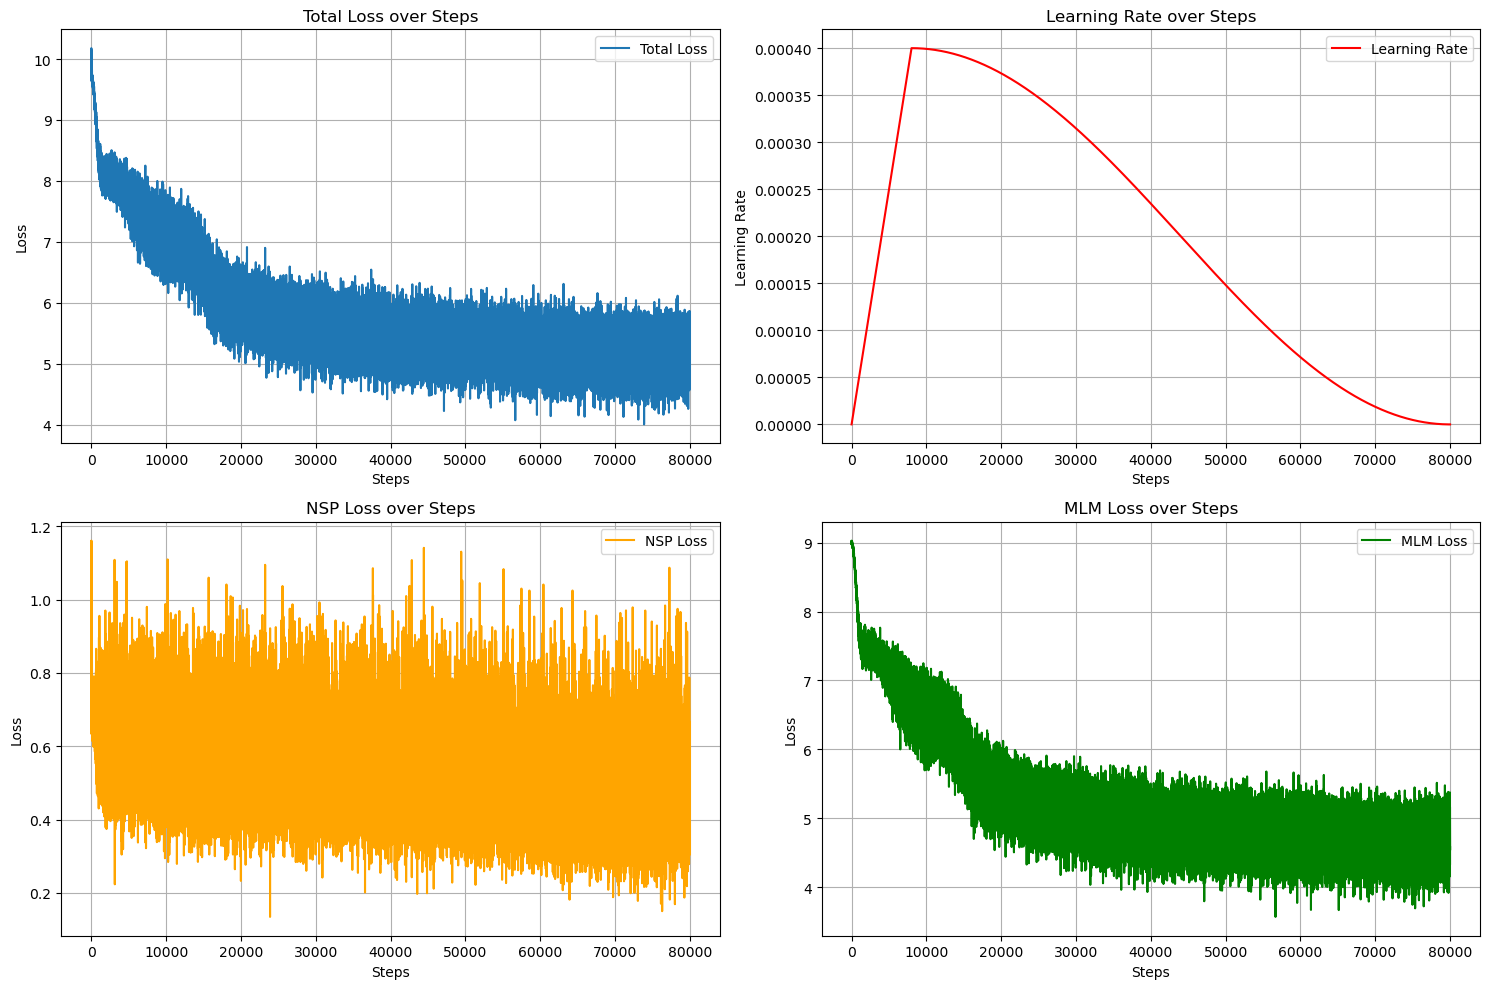

In [14]:
# Loss 및 Learning Rate 시각화
plt.figure(figsize=(15, 10))

# Total Loss
plt.subplot(2, 2, 1)
plt.plot(history['total_loss'], label='Total Loss')
plt.title('Total Loss over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Learning Rate
plt.subplot(2, 2, 2)
plt.plot(history['lr'], label='Learning Rate', color='red')
plt.title('Learning Rate over Steps')
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.legend()

# NSP Loss
plt.subplot(2, 2, 3)
plt.plot(history['nsp_loss'], label='NSP Loss', color='orange')
plt.title('NSP Loss over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# MLM Loss
plt.subplot(2, 2, 4)
plt.plot(history['mlm_loss'], label='MLM Loss', color='green')
plt.title('MLM Loss over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 학습된 모델 로드
print("Loading the trained model...")
model = BERTPretrain(bert_config)
# 저장된 모델 가중치를 불러옵니다. CPU에서 실행할 경우 map_location 인자가 필요합니다.
model.load_state_dict(torch.load("mini_bert_pretrained.pth", map_location=device))
model.to(device)
model.eval()  # 모델을 평가 모드로 설정
print("Model loaded!")

# 2. 빈칸 채우기 (MLM) 테스트 함수
def test_mlm(model, vocab, sentence):
    """
    Masked Language Model 테스트 함수
    :param model: 학습된 BERT 모델
    :param vocab: SentencePiece vocab
    :param sentence: [MASK] 토큰이 포함된 테스트 문장
    """
    # 토큰화 및 텐서 생성
    tokens = vocab.encode_as_pieces(sentence)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]

    # [MASK] 토큰 위치 찾기
    try:
        mask_index = tokens.index("[MASK]")
    except ValueError:
        print("Error: '[MASK]' token not found in the sentence.")
        return

    enc_tokens = [vocab.piece_to_id(p) for p in tokens]
    segments = [0] * len(enc_tokens)

    # 모델 입력용 텐서 준비 (batch_size=1)
    input_tokens = torch.tensor([enc_tokens], dtype=torch.long).to(device)
    input_segments = torch.tensor([segments], dtype=torch.long).to(device)

    # 모델 추론
    with torch.no_grad():
        _, logits_mlm, _ = model(input_tokens, input_segments)

    # [MASK] 위치의 로짓만 추출
    mask_logits = logits_mlm[0, mask_index, :]

    # Top 5 예측
    probs = F.softmax(mask_logits, dim=-1)
    top_5_probs, top_5_indices = torch.topk(probs, 5)

    top_5_tokens = [vocab.id_to_piece(idx.item()) for idx in top_5_indices]

    # 결과 출력
    print(f"\nInput: {sentence}")
    print("-" * 30)
    for i in range(5):
        # " " 기호는 띄어쓰기로 바꿔서 보기 좋게 출력
        token = top_5_tokens[i].replace(' ', ' ')
        print(f"Top {i+1}: {token} (prob: {top_5_probs[i]:.4f})")
    print("-" * 30)
    predicted_word = top_5_tokens[0].replace(' ', '')
    print(f"Prediction: {sentence.replace('[MASK]', predicted_word)}")


# 3. 이어지는 문장 맞추기 (NSP) 테스트 함수
def test_nsp(model, vocab, sent_a, sent_b):
    """
    Next Sentence Prediction 테스트 함수
    :param model: 학습된 BERT 모델
    :param vocab: SentencePiece vocab
    :param sent_a: 첫 번째 문장
    :param sent_b: 두 번째 문장
    """
    # 토큰화 및 텐서 생성
    tokens_a = vocab.encode_as_pieces(sent_a)
    tokens_b = vocab.encode_as_pieces(sent_b)

    tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
    enc_tokens = [vocab.piece_to_id(p) for p in tokens]
    segments = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

    # 패딩
    padding_needed = bert_config.n_seq - len(enc_tokens)
    if padding_needed > 0:
        enc_tokens.extend([0] * padding_needed)
        segments.extend([0] * padding_needed)

    # 모델 입력용 텐서 준비 (batch_size=1)
    input_tokens = torch.tensor([enc_tokens], dtype=torch.long).to(device)
    input_segments = torch.tensor([segments], dtype=torch.long).to(device)

    # 모델 추론
    with torch.no_grad():
        logits_nsp, _, _ = model(input_tokens, input_segments)

    # 결과 분석 (0: NotNext, 1: IsNext)
    probs = F.softmax(logits_nsp, dim=-1)
    is_next_prob = probs[0, 1].item()

    # 결과 출력
    print(f"\nSentence A: {sent_a}")
    print(f"Sentence B: {sent_b}")
    print("-" * 30)
    print(f"Probability that B is the next sentence of A: {is_next_prob:.2%}")
    if is_next_prob > 0.5:
        print("Prediction: YES, it is the next sentence.")
    else:
        print("Prediction: NO, it is not the next sentence.")


# --- 테스트 실행 ---
print("\n" + "="*50)
print(" MLM (Fill-in-the-blank) Test ".center(50, "="))
print("="*50)
test_mlm(model, vocab, "대한민국의 수도는 [MASK]이다.")
test_mlm(model, vocab, "오늘 점심으로 [MASK]을 먹고 싶다.")
test_mlm(model, vocab, "내일 [MASK]에 놀러 갈 예정이다.")


print("\n" + "="*50)
print(" NSP (Next Sentence Prediction) Test ".center(50, "="))
print("="*50)
# Case 1: 이어지는 문장
print("\n--- Case 1: Plausible next sentence ---")
test_nsp(model, vocab, "오늘 날씨가 정말 좋네요.", "공원에 산책하러 가야겠어요.")

# Case 2: 이어지지 않는 문장
print("\n--- Case 2: Unrelated sentence ---")
test_nsp(model, vocab, "오늘 날씨가 정말 좋네요.", "BERT는 구글에서 개발한 언어 모델입니다.")

Loading the trained model...
Model loaded!

========== MLM (Fill-in-the-blank) Test ==========

Input: 대한민국의 수도는 [MASK]이다.
------------------------------
Top 1: ▁같은 (prob: 0.1447)
Top 2: ▁대한민국의 (prob: 0.1148)
Top 3: ▁다음 (prob: 0.0664)
Top 4: ▁가리키는 (prob: 0.0514)
Top 5: 의 (prob: 0.0461)
------------------------------
Prediction: 대한민국의 수도는 ▁같은이다.

Input: 오늘 점심으로 [MASK]을 먹고 싶다.
------------------------------
Top 1: ▁하는 (prob: 0.1775)
Top 2: ▁있는 (prob: 0.1022)
Top 3: ▁등의 (prob: 0.0726)
Top 4: ▁하고 (prob: 0.0663)
Top 5: ▁다음 (prob: 0.0331)
------------------------------
Prediction: 오늘 점심으로 ▁하는을 먹고 싶다.

Input: 내일 [MASK]에 놀러 갈 예정이다.
------------------------------
Top 1: ▁다음 (prob: 0.2908)
Top 2: ▁줄 (prob: 0.0469)
Top 3: ▁날 (prob: 0.0413)
Top 4: ▁같은 (prob: 0.0401)
Top 5: ▁주는 (prob: 0.0388)
------------------------------
Prediction: 내일 ▁다음에 놀러 갈 예정이다.

====== NSP (Next Sentence Prediction) Test =======

--- Case 1: Plausible next sentence ---

Sentence A: 오늘 날씨가 정말 좋네요.
Sentence B: 공원에 산책하러 가야겠어요

/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


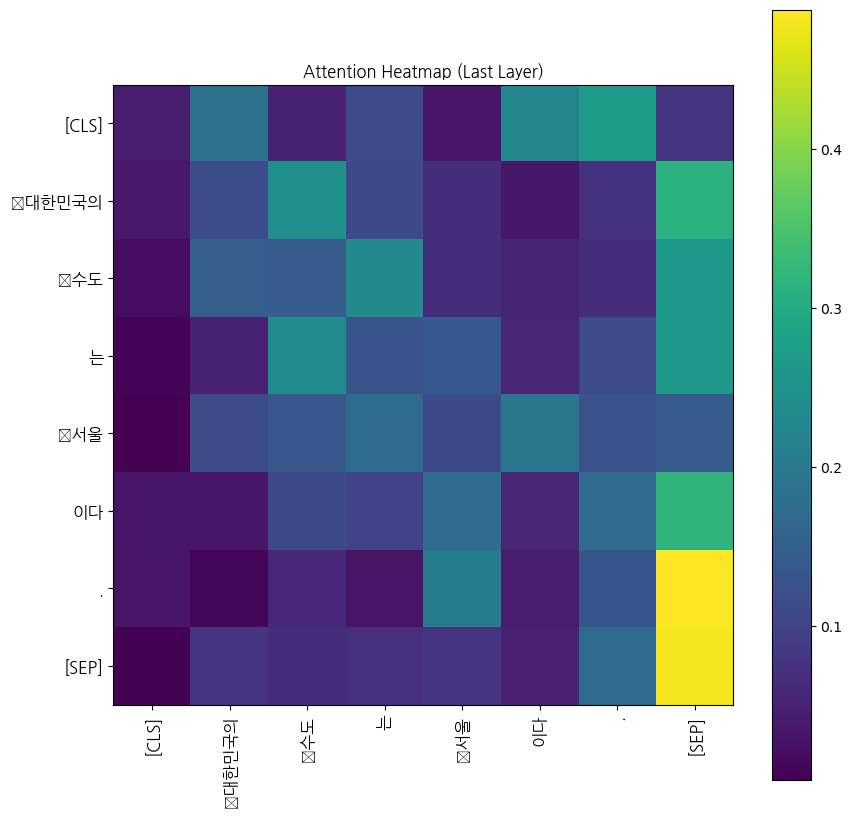

In [16]:
import matplotlib.font_manager as fm

def visualize_attention(model, vocab, sentence):
    # 토큰화 및 텐서 생성
    tokens = vocab.encode_as_pieces(sentence)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]

    enc_tokens = [vocab.piece_to_id(p) for p in tokens]
    segments = [0] * len(enc_tokens)

    input_tokens = torch.tensor([enc_tokens], dtype=torch.long).to(device)
    input_segments = torch.tensor([segments], dtype=torch.long).to(device)

    # 모델 추론 및 어텐션 스코어 얻기
    with torch.no_grad():
        _, _, attn_probs = model(input_tokens, input_segments)

    # 마지막 레이어의 어텐션 스코어를 사용
    # attn_probs 리스트의 마지막 요소, 첫 번째 배치의 스코어
    last_layer_attention = attn_probs[-1][0]

    # 헤드들의 어텐션을 평균내어 (n_seq, n_seq) 크기로 만듬
    # (n_head, n_seq, n_seq) -> (n_seq, n_seq)
    attention_matrix = last_layer_attention.mean(dim=0)

    # 시각화
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(attention_matrix.cpu(), cmap='viridis')

    # 보기 좋게 꾸미기
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=12)

    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, fontproperties=fontprop, rotation=90)
    ax.set_yticklabels(tokens, fontproperties=fontprop)

    fig.colorbar(im, ax=ax)
    plt.title("Attention Heatmap (Last Layer)", fontproperties=fontprop)
    plt.show()

visualize_attention(model, vocab, "대한민국의 수도는 서울이다.")